In [1]:
from __future__ import print_function, division

import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from IPython.display import clear_output
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import scipy
import math
import scipy.interpolate as si
from scipy import interpolate
import pickle
import os.path
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# plt.style.use('dark_background')
#%matplotlib inline

In [3]:
IMG_FOLDER="chars"
UCI_DATASET="ujipenchars2.txt"
LOCAL_DATASET='dataset'
CURRENT_FOLDER="/home/test/Dissertation/"
CHAR_LIST="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
FOREGROUND="white"
TRAIN_DICT={}
TEST_DICT={}
SCALE_X=4
SMOOTH=True
IMG_W=60 # 60
IMG_H=60 # 60
FEATURES= 'fft_angles' # fft_angles, angles
# # best for me dataset
# TRACK_STEP_LEN=30
# MAX_TRACK_SIZE=10
# BATCH_SIZE=50
# NUM_HIDDEN_NEURON=100
# ITERS=5000
TRACK_STEP_LEN= 10 # 30 # отступ между оставляемыми точками при прореживании 
MAX_TRACK_SIZE=30 # 40
BATCH_SIZE=50
MODEL='resnet' # resnet, rnn2, rnn, lstm 
NUM_HIDDEN_NEURON=100
EPOCHS=100
BATCHNORM=True # не работает train/eval по неизвестной причине
DROPOUT=True
DATASET='russian_extra'# russian, russian_extra, uji
IMG_DIVIDER= 100 if DATASET=="uji" else 1.1
ACTIVATION='lrelu' # rrelu,relu, tanh , lrelu, hardswish

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

# Presentation classes.
Define classes for represent bases objects - point, polyline, char

In [4]:
class Point:
  def __init__(self,x,y):
    self.x=x
    self.y=y
  def __str__(self):
    return "("+str(self.x)+","+str(self.y)+")"
  __repr__ = __str__


class Poly:
  def __init__(self):
    self.points=[]
    self.angles=[]
    self.lens=[]
    self.times=[]
    self.speeds=[]
    self.fft_angles=[]
    self.fft_speeds=[]
    self.image=[]
  def add(self,point,time=None):
    self.points.append(point)
    if not time is None:
      self.times.append(time)
  def calculate_angles(self):
    if len(self.points)==0:
      return
    if len(self.points)==1:
      self.angles.append(0)
      self.lens.append(0)
      return
    for i in range(0,len(self.points)-1):
      angle=math.atan2(self.points[i+1].y-self.points[i].y,self.points[i+1].x-self.points[i].x)
      if angle<0: angle=2*math.pi+angle
      self.angles.append(angle)
      self.lens.append(math.sqrt((self.points[i+1].y-self.points[i].y)**2+(self.points[i+1].x-self.points[i].x)**2))
  def calculate_image(self):
    if len(self.points)==0:
      return 
    self.image = [ [0] * IMG_W for _ in range(IMG_H)] 
    for p in self.points:
      H=int(p.y/IMG_DIVIDER)
      W=int(p.x/IMG_DIVIDER)
      if W>=IMG_W or  H>=IMG_H: continue
      self.image[H][W]=255
      pass
  def calc_angle(self,point,other):
    angle=0
    for p in other:
      a=math.atan2(p.y-point.y,p.x-point.x)
      if a<0: a+=2*math.pi
      angle+=a
    return angle/len(other)  
  def calc_dist(self,point1,point2):
    return math.sqrt((point2.x-point1.x)**2+(point2.y-point1.y)**2)
  def calc_fft(self,sequence):
    DURATION=1
    SAMPLE_RATE=len(sequence)
    N = SAMPLE_RATE * DURATION
    yf = rfft(sequence)
    xf = rfftfreq(N, 1 / SAMPLE_RATE)
    return xf, np.abs(yf)

  def calc_vo_smothie(self):
    self.drop_dup() 
    if len(self.points)==1:
      return
    for i in range(0,len(self.points)-1):
      dx=self.points[i+1].x-self.points[i].x
      dy=self.points[i+1].y-self.points[i].y
      self.lens.append(math.sqrt(dx**2+dy**2))
      angle=self.calc_angle(point=self.points[i],other=[self.points[i+1]])
      self.angles.append(angle)
      if len(self.times)>0:self.speeds.append(self.lens[-1]/self.times[i])
    _,self.fft_angles=self.calc_fft(self.angles) 
    _,self.fft_speeds=self.calc_fft(self.speeds)

  def calc_vs_smothie(self):
    self.drop_dup() 
    if len(self.points)==1:
      return
    f=[]
    for i in range(0,len(self.points)):
      if i!=0:
        f_=[(self.points[i].x-self.points[i-1].x),(self.points[i].y-self.points[i-1].y)]
        f.append(f_)
    v=np.array([0,0])
    m=1000
    nu=40
    x1=[]
    y1=[]
    x1.append(self.points[0].x)
    y1.append(self.points[0].y)
    #строим новую сглаженную траекторию
    for i in range(0,len(f)):
      for j in range(0,40):
        x1_=x1[-1]+v[0]  
        y1_=y1[-1]+v[1]
        f_=np.array(f[i])
        v=v+f_/m-nu*v/m
        x1.append(x1_)
        y1.append(y1_)    
    #прореживаем и считаем углы и длинны    
    self.lens=[]
    self.angles=[]
    self.points=[]
    self.points.append(Point(x1[0],y1[0]))
    angle=self.calc_angle(point=self.points[0], other=[Point(x1[1],y1[1]),Point(x1[2],y1[2]),Point(x1[3],y1[3])])
    self.angles.append(angle)
    step=0.
    for i in range(1,len(x1)-3):
      step+=self.calc_dist(self.points[-1],Point(x1[i],y1[i]))
      if step>TRACK_STEP_LEN:
        self.points.append(Point(x1[i],y1[i]))
        angle=self.calc_angle(self.points[-1],[Point(x1[i+1],y1[i+1]),Point(x1[i+2],y1[i+2]),Point(x1[i+3],y1[i+3])]) 
        self.angles.append(angle)
        self.lens.append(step)
        step=0.
    _,self.fft_angles=self.calc_fft(self.angles) 

  def drop_dup(self):
    nodup_points=[]
    nodup_times=[]
    for i in range(0,len(self.points)-1):
      if self.points[i].x!=self.points[i+1].x or self.points[i].y!=self.points[i+1].y:
        nodup_points.append(self.points[i])
        if len(self.times)>0:nodup_times.append(self.times[i])
    if len(nodup_points)==0:
      nodup_points.append(self.points[0])    
      if len(self.times)>0: nodup_times.append(self.times[0])    
    self.points=nodup_points
    if len(self.times)>0: self.times=nodup_times
  def move(self,dx,dy):
    for p in self.points:
      p.x+=dx
      p.y+=dy

  def get_min(self):
    min_x = self.points[0].x
    min_y = self.points[0].y
    for p in self.points:
      if min_x>p.x: min_x=p.x
      if min_y>p.y: min_y=p.y
    return min_x,min_y  

  def __len__(self):
    return len(self.points)-1


class Char:
  def __init__(self,name):
    self.name=name
    self.polys=[]
  def singlePolys(self):
      single=Poly()
      for poly in self.polys:
        if len(poly.points)>1:
          single.points.extend(poly.points)
          single.angles.extend(poly.angles)
          single.lens.extend(poly.lens)
          single.times.extend(poly.times)
          single.speeds.extend(poly.speeds)
          single.fft_angles.extend(poly.fft_angles)
          single.fft_speeds.extend(poly.fft_speeds)
      return single
  def singleImage(self):
    if len(self.polys) ==1: 
      return self.polys[0].image
    self.image = [ [0] * IMG_W for _ in range(IMG_H)] 
    for poly in  self.polys:
      for j in range(IMG_H):
        for i in range(IMG_W):
          # print("{},{}".format(j,i))
          if poly.image[j][i] +  self.image[j][i] == 0:
            continue
          else:
            self.image[j][i] =255   
    return self.image

  def appendPoly(self):
    self.polys.append(Poly());
  def appendPoint(self,point,time=None):
    self.polys[-1].add(point,time)
  def flip_vert(self):
    for poly in self.polys:
      for point in poly.points:
        point.y=5000-point.y
  def flip_hor(self):
    for poly in self.polys:
      for point in poly.points:
        point.x=10040-point.x
  def calculate_angles(self):
    for poly in self.polys:
      poly.calculate_angles()
  def calculate_images(self):
    for poly in self.polys:
      poly.calculate_image()    
  def drop_dup(self):
    for poly in self.polys:
      poly.drop_dup()
  def calc_vs_smothie(self):
    for poly in self.polys:
      poly.calc_vs_smothie() 
    self.calculate_images()     
  def calc_vo_smothie(self):
    for poly in self.polys:
      poly.calc_vo_smothie()    
    self.calculate_images()  
  def get_min(self):
    min_x,min_y=self.polys[0].get_min()
    for i in range(1,len(self.polys)):
      min_x_,min_y_=self.polys[i].get_min()
      if min_x>min_x_: min_x=min_x_
      if min_y>min_y_: min_y=min_y_
    return min_x,min_y 
  def move (self):
    min_x,min_y=self.get_min()
    for p in self.polys:
      p.move(-min_x,-min_y)

  def __len__(self):
    len_=0
    for poly in self.polys: 
      len_+=len(poly)
    return len_
  def __str__(self):
    s=""
    for _ in self.polys:
      s+="_"+str(len(_.points))
    return self.name + s
  __repr__ = __str__

def addTrainChar(name,char):
  if TRAIN_DICT.get(name) == None:
    TRAIN_DICT[name]=[]
  TRAIN_DICT[name].append(char)


def addTestChar(name,char):
  if TEST_DICT.get(name) == None:
    TEST_DICT[name]=[]
  TEST_DICT[name].append(char)

def plot_curve1(plt,ax,char):
 if ax is None:
        fig, ax = plt.subplots()
 for poly in char.polys:
    x_=[]
    y_=[]  
    for i in range(0,len(poly.points)):
      x_.append(poly.points[i].x)
      y_.append(poly.points[i].y)
    ax.plot( x_ ,y_,'r.')

def plot_curve2(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    for poly in char.polys:
      for i in range(0,len(poly.points)):
        if i==len(poly.points)-1:
          break
        x_=[]
        y_=[]  
        x_.append(poly.points[i].x)
        x_.append(poly.points[i+1].x)
        y_.append(poly.points[i].y)
        y_.append(poly.points[i+1].y)
        len_=math.sqrt((x_[1]-x_[0])**2+(y_[1]-y_[0])**2)
        ax.plot( x_ ,y_,linewidth=5,color=str(3*len_/255.))

def plot_curve3(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    len_=0
    for poly in char.polys:
      for i in range(0,len(poly.lens)-1):
        x_=[]
        y_=[]
        x_.append(len_)
        len_+=poly.lens[i]
        x_.append(len_)
        y_.append(100*poly.angles[i])
        y_.append(100*poly.angles[i+1])
        ax.plot( x_ ,y_,linewidth=2,color='b')

def plot_curve4(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    x_=[]
    y_=[]  
    len_=0
    for poly in char.polys:
      for i in range(0,len(poly.speeds)):
        len_+=poly.lens[i]
        x_.append(len_)
        y_.append(poly.speeds[i])
    ax.plot( x_ ,y_,linewidth=2,color='g')

def plot_curve5(plt,ax,char):
    if ax is None:
        fig, ax = plt.subplots()
    img=char.singleImage()
    img=np.array(img)
    ax.imshow(img, origin='lower')



# Load russian local dataset  

In [5]:
def build_local_datatset():
  fn=os.path.join(CURRENT_FOLDER, LOCAL_DATASET)
  dirs=os.listdir(fn)
  for dir in dirs:
    for fi in os.listdir(os.path.join(fn,dir)):
      if len(fi)==1:
        with open(os.path.join(fn,dir,fi), encoding="utf-8") as f,open(os.path.join(fn,dir,fi+"_times"), encoding="utf-8") as ft:
          try:
            data = eval(f.readline())
            times=eval(ft.readline())
          except:
            data=[]
            times=[]  
          print("{}/{}/{}  ({}:{})".format(fn,dir,fi,len(data),len(times)))
          class_name=fi
          char_=Char(fi)
          char_.appendPoly()
          j=0
          for i in range(len(data)//2):
            x=int(data[j])
            y=int(data[j+1])
            t=int(times[i])
            j+=2
            char_.appendPoint(Point(x,y),t)
          char_.move()  
          if len(data) > 0: 
            if SMOOTH:
              char_.calc_vs_smothie()  
            else:
              char_.calc_vo_smothie()    
            if random.random()<0.8: 
              addTrainChar(class_name,char_)
            else: 
              addTestChar(class_name,char_)

      

In [6]:
# ## build_local_datatset() - ! только если нужна принудительная разовая 
# ##                          загрузка прямо тут, а не из датасета

# #---------
# #Это можно раскоментировать чтобы построить графику по датасету
# #В остальное время держать закоментированным, т.к. не сработает
# #импорт классов из этого ноутубка
# CHAR='А'
# CNUM =1
# print(TRAIN_DICT[CHAR])
# TRAIN_DICT[CHAR][CNUM]
# fig = plt.figure(figsize = (12,12))
# ax1 = fig.add_subplot(3,3,1)
# ax2 = fig.add_subplot(3,3,2)
# ax3 = fig.add_subplot(3,3,3)
# ax4 = fig.add_subplot(3,3,4)
# ax5 = fig.add_subplot(3,3,5)
# ax6 = fig.add_subplot(3,3,6)
# plot_curve1(plt,ax1,TRAIN_DICT[CHAR][CNUM])
# plot_curve2(plt,ax2,TRAIN_DICT[CHAR][CNUM])
# plot_curve3(plt,ax3,TRAIN_DICT[CHAR][CNUM])
# plot_curve4(plt,ax5,TRAIN_DICT[CHAR][CNUM])

# xf=np.arange(0, len(TRAIN_DICT[CHAR][CNUM].polys[0].fft_angles), 1, dtype=float)
# print(len(xf))
# ax4.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_angles)
# # ax6.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_speeds)


# Load russian extra dataset

In [5]:
def build_local_extra_datatset():
    fn=os.path.join(CURRENT_FOLDER, LOCAL_DATASET)
    dirs=os.listdir(fn)
    for dir in dirs:
        for fi in os.listdir(os.path.join(fn,dir,"extra")):
            if "."  in fi or "_"  in fi: continue  
            with open(os.path.join(fn,dir,"extra",fi), encoding="utf-8") as f,open(os.path.join(fn,dir,"extra",fi+"_times"), encoding="utf-8") as ft:
                  try:
                        data = eval(f.readline())
                        times=eval(ft.readline())
                  except:
                        data=[]
                        times=[]  
                  print("{}/{}/{}/{}  ({}:{}) writer:{}".format(fn,dir,"extra",fi,len(data),len(times),dir[0:-2]))
                  writer=dir[0:-2]
                  class_name=fi+"_"+writer
                  char_=Char(class_name)
                  char_.appendPoly()
                  j=0
                  for i in range(len(data)//2):
                        x=int(data[j])
                        y=int(data[j+1])
                        t=int(times[i])
                        j+=2
                        char_.appendPoint(Point(x,y),t)
                  char_.move()  
                  if len(data) > 0: 
                    if SMOOTH:
                          char_.calc_vs_smothie()  
                    else:
                          char_.calc_vo_smothie()    
                    if random.random()<0.8: 
                          addTrainChar(class_name,char_)
                    else: 
                          addTestChar(class_name,char_)

      

[выпей_w_0_356, выпей_w_0_461]
179


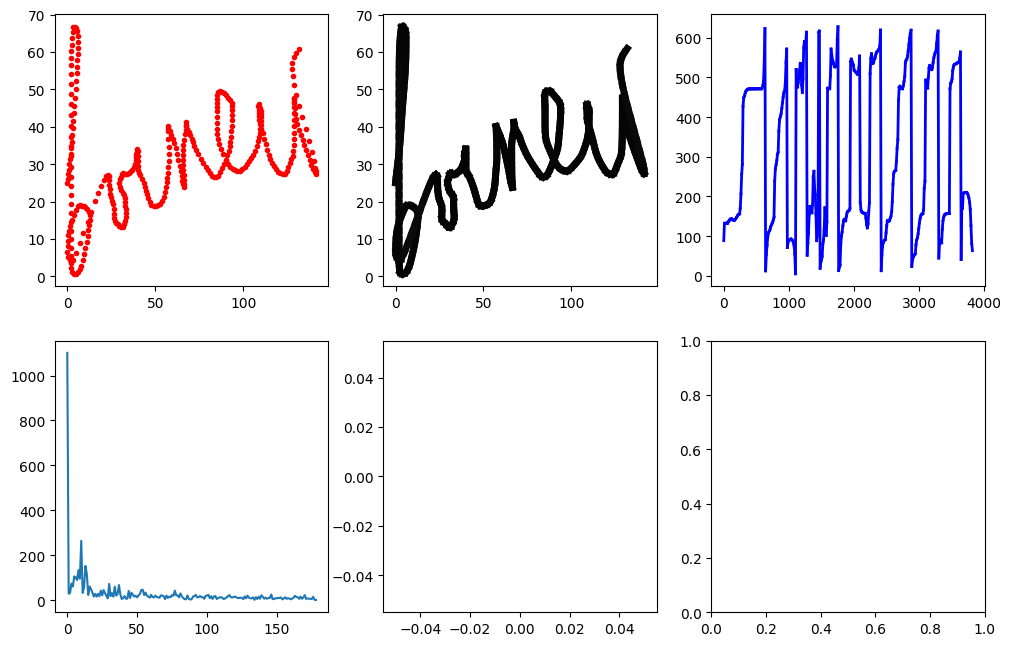

In [10]:
# # ## build_local_extra_datatset() - ! только если нужна принудительная разовая 
# # ##                          загрузка прямо тут, а не из датасета

# # #---------
# # #Это можно раскоментировать чтобы построить графику по датасету
# # #В остальное время держать закоментированным, т.к. не сработает
# # #импорт классов из этого ноутубка
# CHAR='выпей_w_0'
# CNUM =0
# print(TRAIN_DICT[CHAR])
# TRAIN_DICT[CHAR][CNUM]
# fig = plt.figure(figsize = (12,12))
# ax1 = fig.add_subplot(3,3,1)
# ax2 = fig.add_subplot(3,3,2)
# ax3 = fig.add_subplot(3,3,3)
# ax4 = fig.add_subplot(3,3,4)
# ax5 = fig.add_subplot(3,3,5)
# ax6 = fig.add_subplot(3,3,6)
# plot_curve1(plt,ax1,TRAIN_DICT[CHAR][CNUM])
# plot_curve2(plt,ax2,TRAIN_DICT[CHAR][CNUM])
# plot_curve3(plt,ax3,TRAIN_DICT[CHAR][CNUM])
# plot_curve4(plt,ax5,TRAIN_DICT[CHAR][CNUM])

# xf=np.arange(0, len(TRAIN_DICT[CHAR][CNUM].polys[0].fft_angles), 1, dtype=float)
# print(len(xf))
# ax4.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_angles)
# # ax6.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_speeds)

# Load UCI dataset

In [9]:
def build_uci_datatset():
  fn=os.path.join(CURRENT_FOLDER, UCI_DATASET)
  i=0
  with open(fn, encoding="utf-8") as file:
    i+=1
    file_contents = file.read()
  step_0 = file_contents.split('//')
  del(step_0[0]); del(step_0[0]); del(step_0[0]); del(step_0[0])
  for block in step_0:
    try:
      class_name=block.split()[2]
    except Exception:
      i+=1
      continue
    # отбрасываем лишние    
    if CHAR_LIST.find(class_name) == -1: 
      i+=1
      continue 
    words=block.split('WORD')
    del(words[0])
    wordnum=0
    for word in words:
      if len(class_name)>1:
        continue
      char_=Char(class_name)
      print(class_name, end='')
      # sys.stdout.write(f"\r{class_name}") 
      # analize character
      # count graphical elements in character
      num_word_elements=int(word.split('NUMSTROKES')[1].split()[0])
      for j in range(num_word_elements):
        # get graphical elements in character
        word_elements=word.split('POINTS')
        ##print(word_elements[0]) # Здесь "b trn_UJI_W01-02"
        #scale=1
        #if word_elements[0].find("UPV")!=-1: scale=1/1.52
        #sample_type="trn"
        #if word_elements[0].find("tst_")!=-1: sample_type="tst"
        del(word_elements[0])
        char_.appendPoly()
        points=word_elements[j].split()
        del(points[0])
        del(points[0])
        for x,y in zip(points[0::2], points[1::2]):
          #char_.appendPoint(Point(int(scale*int(x)),int(scale*int(y))))
          char_.appendPoint(Point(int(x)*SCALE_X,int(y)*SCALE_X))
      wordnum+=1
      char_.flip_vert()
      # char_.flip_hor()
      char_.move()
      if SMOOTH:
        char_.calc_vs_smothie()  
      else:
        char_.calc_vo_smothie()   
      char_.calc_vs_smothie()
      # if sample_type=="trn":
      #   addTrainChar(class_name,char_)
      # else:
      #   addTestChar(class_name,char_)  
      if  random.random()<0.8:
        addTrainChar(class_name,char_)
      else:
        addTestChar(class_name,char_)  
    i+=1

In [10]:
# ## build_uci_datatset()  - ! только если нужна принудительная разовая 
# ##                          загрузка прямо тут, а не из датасета

# #---------
# #Это можно раскоментировать чтобы построить графику по датасету
# #В остальное время держать закоментированным, т.к. не сработает
# #импорт классов из этого ноутубка
# CHAR='a'
# CNUM = 1
# # print(TRAIN_DICT[CHAR])
# # TRAIN_DICT[CHAR][CNUM]
# fig = plt.figure(figsize = (30,30))
# ax1 = fig.add_subplot(3,2,1)
# ax2 = fig.add_subplot(3,2,2)
# ax3 = fig.add_subplot(3,2,3)
# ax4 = fig.add_subplot(3,2,4)
# ax5 = fig.add_subplot(3,2,5)
# ax6 = fig.add_subplot(3,2,6)
# plot_curve1(plt,ax1,TRAIN_DICT[CHAR][CNUM])
# plot_curve2(plt,ax2,TRAIN_DICT[CHAR][CNUM])
# plot_curve3(plt,ax3,TRAIN_DICT[CHAR][CNUM])
# plot_curve4(plt,ax5,TRAIN_DICT[CHAR][CNUM])
# plot_curve5(plt,ax6,TRAIN_DICT[CHAR][CNUM])
# xf=np.arange(0, MAX_TRACK_SIZE, 1, dtype=float)
# print(len(xf))
# ax4.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_angles[:MAX_TRACK_SIZE])
# # ax6.plot(xf, TRAIN_DICT[CHAR][CNUM].polys[0].fft_speeds)
# from matplotlib import colors
# cmap = colors.ListedColormap(['Blue','red'])
# ax5.pcolor(TRAIN_DICT[CHAR][CNUM].singleImage()[::-1],cmap=cmap,edgecolors='k', linewidths=3)
# # # print(TRAIN_DICT[CHAR][CNUM].polys[0].image)

# extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig('fig_char_'+CHAR+str(CNUM)+'.png', bbox_inches=extent.expanded(1.1, 1.2))

In [11]:
# poly=TRAIN_DICT[CHAR][CNUM].polys[0]
# image = [ [0] * IMG_W for _ in range(IMG_H)] 
# # print(image)
# for p in poly.points:
#     y=int(p.y/IMG_DIVIDER)
#     x=int(p.x/IMG_DIVIDER)
#     print("{},{}".format(y,x))
#     image[y][x]=255
# print("---")
# # print(image)
# plt.pcolor( image)
# plt.show()
# # print(image)

# Prepare dataset. 
Load from source, transform to internal form. Save and load to intermediate storage datasert file.

In [8]:
class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            # from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            # from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            # from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)

class CustomPickler(pickle.Pickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            # from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            # from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            # from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)


def run_():
    global TRAIN_DICT
    global TEST_DICT
    if os.path.exists(os.path.join(CURRENT_FOLDER,'train_dict.p')):
        f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict.p'), 'rb')
        f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict.p'), 'rb')
        TRAIN_DICT = CustomUnpickler(f_train_dict).load()
        TEST_DICT = CustomUnpickler(f_test_dict).load()
        f_train_dict.close()
        f_test_dict.close()
    else:
        if DATASET == 'russian':
            build_local_datatset()
        elif DATASET == 'russian_extra':
            build_local_extra_datatset()
        else:
            build_uci_datatset()
        f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict.p'), 'wb')
        f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict.p'), 'wb')
        CustomPickler(f_train_dict).dump(TRAIN_DICT)
        CustomPickler(f_test_dict).dump(TEST_DICT)
        f_train_dict.close()
        f_test_dict.close()



In [9]:
if __name__ == "__main__":
    run_()

/home/test/Dissertation/dataset/w_7_3/extra/булок  (306:153) writer:w_7
/home/test/Dissertation/dataset/w_7_3/extra/cъешь  (450:225) writer:w_7
/home/test/Dissertation/dataset/w_7_3/extra/французских  (842:421) writer:w_7
/home/test/Dissertation/dataset/w_7_3/extra/чаю  (290:145) writer:w_7
/home/test/Dissertation/dataset/w_7_3/extra/этих  (330:165) writer:w_7
/home/test/Dissertation/dataset/w_7_3/extra/да  (176:88) writer:w_7
/home/test/Dissertation/dataset/w_7_3/extra/мягких  (424:212) writer:w_7
/home/test/Dissertation/dataset/w_7_3/extra/ещё  (282:141) writer:w_7
/home/test/Dissertation/dataset/w_7_3/extra/выпей  (362:181) writer:w_7
/home/test/Dissertation/dataset/w_4_3/extra/булок  (246:123) writer:w_4
/home/test/Dissertation/dataset/w_4_3/extra/cъешь  (290:145) writer:w_4
/home/test/Dissertation/dataset/w_4_3/extra/французских  (582:291) writer:w_4
/home/test/Dissertation/dataset/w_4_3/extra/чаю  (200:100) writer:w_4
/home/test/Dissertation/dataset/w_4_3/extra/этих  (234:117) wr

In [14]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print(len(list(TRAIN_DICT.keys())))
print(list(TRAIN_DICT.keys()).sort())
print(len(list(TEST_DICT.keys())))
print(list(TEST_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])
print(all_size)

76
None
76
None
2245
